In [1]:
#IMPORT LIBRARIES
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
from os import path
from itertools import *
from __future__ import division
import math
import numpy.polynomial.polynomial as poly
import random
from scipy.optimize import least_squares as leastsq
from scipy.optimize import minimize
% matplotlib inline
from sklearn.model_selection import train_test_split, KFold
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lmfit import  Model


In [2]:
#Input parameters:
i = 0 #starting number of iteration
number_of_files = 8 #number of files in directory
width = 2.5 #mm
thickness = 0.042 #mm
area = width * thickness 

sourcePath = 'C:\\Users\\Inance\\Documents\\Thesis\\Experiments\\Tensile_Tests\\Data\\Weft_Single_Thread'
list_of_source_files = glob.glob(sourcePath + '/*.TXT')
outpath = 'C:\\Users\\Inance\\Documents\\Thesis\\Experiments\\Fitted_Curves'

In [3]:
#Loop through files & save data in list form
def GetSourceFiles(list_of_source_files,i):
    with open(list_of_source_files[i]) as source_file:
        lst = [] 
        for line in source_file:
            lst.append([ float(x) for x in line.split()])
        force = np.array([ x[2] for x in lst])
        stress = force/area
        strain = (np.array([ x[3] for x in lst]))
    return stress,strain

In [4]:
def FilterData(ss,st,i):
    ss = ss.tolist() #stress
    st = st.tolist() #strain
    maxIndex = ss.index(max(ss)) #finds stress index
    ss,st  = zip(*[[ss[i], st[i]] for i in range(len(ss)) if i<= maxIndex]) #after max value, discard the rest of the values
    t = [x * 0.1 for x in range(len(ss))]  #time
    return ss,st,t

In [5]:
def addEVERYTHING(a):
    FINALlist = []
    for sample in a:
        FINALlist += sample
    return FINALlist

In [6]:
def getData(list_of_source_files,i):
    stress,strain = GetSourceFiles(list_of_source_files,i)    #get stress & strian of a sample
    stress,strain,time = FilterData(stress,strain,i) #remove values after max value
    stress_strain_time = np.empty((len(stress), 0)).tolist()  #initialize an empty list
    for j in range(len(stress)):  #loop through 
        stress_strain_time[j]=[stress[j],strain[j],time[j]] #make coordinate (stress,strain,time) for entire sample
    #a = zip(stress,strain,time)
    return stress_strain_time

In [7]:
#MAIN
ALLlist=[]
newList = np.empty((number_of_files, 0)).tolist()

for i in range(number_of_files): #loop through the specified number of files
    stress_strain_time = getData(list_of_source_files,i) #get a mixed,coordinate type sample
    newList[i] = stress_strain_time #save in a new list
    ALLlist.append(stress_strain_time) #get one list with all the samples' data
b = addEVERYTHING(ALLlist)
np.random.shuffle(b) #randomize the all the data points in coordinate form
print(len(b))
#b is the matrix with all the randomized data

2324


# Train-Test-Split Method

https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test

In [8]:
Stress,Strain,Time = zip(*b) #split the matrix into 3 seperate lists.
Stress = np.array(Stress).reshape(len(Stress),1)
time_train, time_test, strain_train, strain_test, stress_train, stress_test = train_test_split(Time,Strain,Stress, test_size=0.33)

In [9]:
#TRAINING DATA
x_TRAIN = np.array([strain_train,time_train])
data_TRAIN = stress_train.reshape(1,len(stress_train)).tolist()
data_TRAIN = sum(data_TRAIN, [])
#TESTING DATA
x_TEST = np.array([strain_test,time_test])
data_TEST = stress_test.reshape(1,len(stress_test)).tolist()
data_TEST = sum(data_TEST, [])

# Theory

### MAXWELL MODEL

The Maxwell model consists of a linear elastic spring and a linear viscous dashpot element  connected in a series as seen below.
 
Maxwell model:
 ![Maxwell Model](maxwell.JPG "Figure 1 - Maxwell Model")

Maxwell equation:
$$\frac{d\varepsilon}{dt} = \frac{1}{E}\frac{d\sigma}{dt} + \frac{\sigma}{\eta}$$

Maxwell constitutive formula:
$$\sigma = \frac{\varepsilon}{\frac{1}{\eta_1}t+\frac{1}{E_1}}$$

### H-K MODEL

The three-parameter K-H (Standard) model consists of the Kelvin model ($E1, \eta1$) and a spring coupled in a series as seen below.
 
H-K model:
 ![H-K Model](hkmodel.JPG "Figure 1 - H-K Model")

H-K equation:   
$$\varepsilon=\frac{\sigma}{E_1} + \frac{\sigma}{E_2} - \frac{\eta_2}{E_2}\dot{\varepsilon}$$

H-K constitutive equation:   
$$\sigma=\frac{\varepsilon}{(\frac{1}{E_1}+\frac{1}{E_2}(1-\exp(-\frac{E_2}{\eta_2}t)}$$

### BURGERS MODEL

The four-parameter Burgers model consists of two simple models, the Maxwell model ($E1, \eta1$) and the Voigt–Kelvin model($E2, \eta2$) coupled in a series as seen below.
 
Burgers model:
 ![Voigt–Kelvin Model](burger.JPG "Figure 1 - Burgers Model")

Burgers constitutive equation:   
$$\sigma=E_1\varepsilon(1+\frac{E_1t}{\eta_1}+\frac{E_1}{E_2}(1-\exp(-\frac{E_2}{\eta_2}t))$$


# Coding

In [10]:
#Constitutive Models:

def Maxwell_Model(x,E1,N1):
    e,t = x
    return (e/(((1/N1)*t)+(1/E1))) 


def HK_Model(x,E1,E2,N2):
    e,t = x
    return (e)/((1/E1)+((1/E2)*(1-np.exp(E2*t/N2))))


def Burgers_Model(x,E1,E2,N1,N2):
    e,t = x
    return (e*E1)/(1+((E1/N1)*t)+(E1/E2)*(1-np.exp((-E2/N2*t))))

In [11]:
#Graphs Function:
def Graph(x,y,label,result):
    plt.plot(x, y,'bo',label="Training data")
    plt.plot(x, result.init_fit, '.k', label="Initial guess")
    plt.plot(x, result.best_fit, '.r',label=label)
    plt.ylim([0,600])
    plt.legend(loc='lower right')
    plt.xlabel('Strain [mm/mm]')
    plt.ylabel('Stress [MPa]')
    plt.title('Model training')
    plt.show()
    return

Number of data points: 1557
Number of variables: 2
Refined variables: {'E1': 4348.2876997098138, 'N1': 81594.294056831612}


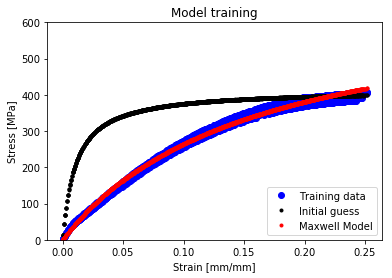

Number of data points: 1557
Number of variables: 3
Refined variables: {'E2': -4578.197987583465, 'E1': 3695.3585817186636, 'N2': -142983.78215315394}


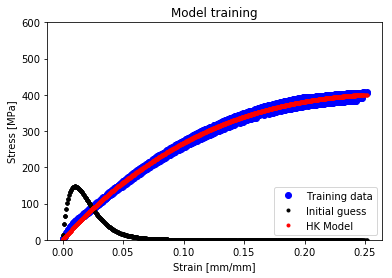

Number of data points: 1557
Number of variables: 4
Refined variables: {'E2': 6358.3123754582093, 'E1': 13643.436672471227, 'N1': 81785.19193008235, 'N2': 3768.8052312577947}


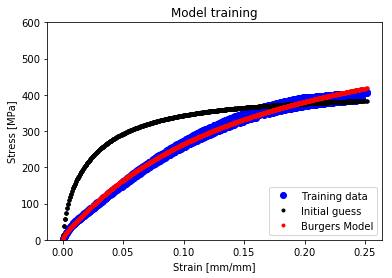

In [12]:
#TRAIN models on TRAIN DATA
x_train = x_TRAIN 
y_train = data_TRAIN

Models = [Maxwell_Model,HK_Model,Burgers_Model]
Names = ["Maxwell Model","HK Model","Burgers Model"]
i=0
for i in range(3):
    model = Model(Models[i])
    if i == 0:
        result = model.fit(y_train, x=x_train, E1=40e3,N1=50e3) #Maxwell Model
    if i == 1:
        result = model.fit(y_train, x=x_train, E1=40e3,E2=-40e3,N2=-50e3) #HK Model
    if i == 2:
        result = model.fit(y_train, x=x_train, E1=40e3,E2=40e3,N1=50e3,N2=50e3) #Burgers Model
    #print(result.fit_report())
    print("Number of data points:",result.ndata)
    print("Number of variables:",result.nvarys)
    print("Refined variables:",result.best_values)
    Graph(x_train[0],y_train,Names[i],result)
    #result(dir)

HK Model parameters calculated on training data: 
 {'E2': -4578.197987583465, 'E1': 3695.3585817186636, 'N2': -142983.78215315394}


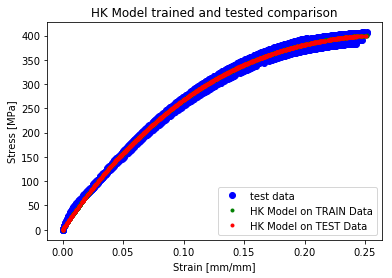

In [13]:
#TEST Models on TEST DATA
x_test = x_TEST
y_test = data_TEST
x_train = x_TRAIN 
y_train = data_TRAIN

#Get train curve again:
modelTRAIN = Model(HK_Model)
result = modelTRAIN.fit(y_train, x=x_train, E1=40e3,E2=-40e3,N2=-50e3)
print("HK Model parameters calculated on training data:",'\n',result.best_values) 

#Get test curve based on train parameters:
modelTEST = HK_Model(x_test,E1=result.best_values['E1'],E2=result.best_values['E2'],N2=result.best_values['N2'])

plt.title('HK Model trained and tested comparison')
plt.plot(x_train[0], y_train,'bo',label="test data")
plt.plot(x_train[0],result.best_fit , '.g',label="HK Model on TRAIN Data")
plt.plot(x_test[0], modelTEST, '.r',label="HK Model on TEST Data")
plt.xlabel('Strain [mm/mm]')
plt.ylabel('Stress [MPa]')
#plt.ylim([0,600])
plt.legend(loc='lower right')
plt.show()

Refined variables: {'E1': 4330.4316696806836, 'N1': 82301.900295836444}


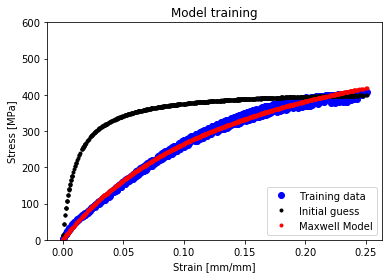

Refined variables: {'E2': -3910.0053807916756, 'E1': 3735.1332158999107, 'N2': -135711.426814562}


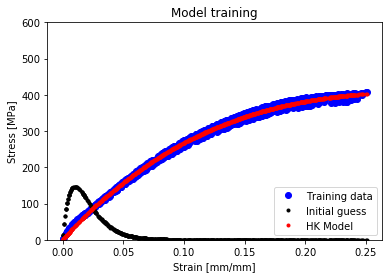

Refined variables: {'E2': 6797.4936047939218, 'E1': 11850.035526470507, 'N1': 82495.91769121158, 'N2': 4210.1504435940351}


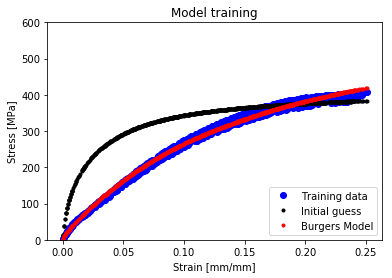

In [14]:
#TEST Models on TEST DATA - check how parameters differ in a different model based on the testing data
x_test = x_TEST
y_test = data_TEST

Models = [Maxwell_Model,HK_Model,Burgers_Model]
Names = ["Maxwell Model","HK Model","Burgers Model"]
i= 0
for i in range(3):
    model = Model(Models[i])
    if i == 0:
        result = model.fit(y_test, x=x_test, E1=40e3,N1=50e3) #Maxwell Model
    if i == 1:
        result = model.fit(y_test, x=x_test, E1=40e3,E2=-40e3,N2=-50e3) #HK Model
    if i == 2:
        result = model.fit(y_test, x=x_test, E1=40e3,E2=40e3,N1=50e3,N2=50e3) #Burgers Model
    print("Refined variables:",result.best_values)
    Graph(x_test[0],y_test,Names[i],result)

# Error vs Iteration

In [15]:
def get_H_K_model(HKvars,x,data):
    #data = Stresses
    E1 =  HKvars[0] #Spring 1 Elastic Modulus
    E2 =  HKvars[1] #Spring 2 Elastic Modulus
    N2 = HKvars[2] #Dashpot 1 Viscosity
    e = x[0] #Strains
    t = x[1] #Times
    
    model =  (e)/((1/E1)+((1/E2)*(1-np.exp(E2*t/N2))))#equation to fit curve
    residual = data - model
    
    return residual

In [16]:
def compute_error(constants,data,x):
    totalError = 0
    E1 = constants[0] #Spring 1 Elastic Modulus
    E2 = constants[1] #Spring 2 Elastic Modulus
    N2 = constants[2] #Dashpot 1 Viscosity
    saveError = []
    
    for i in range(0, len(data)):
        e = x[0][i] #Strains
        t = x[1][i] #Times
        y = data[i] #stress
        
        y_tilder = (e)/((1/E1)+((1/E2)*(1-np.exp(E2*t/N2))))#eqn

        totalError += (y - y_tilder) ** 2
        saveError.append(totalError/i)
    R2 = totalError / float(len(data))
    return R2, saveError

In [17]:
def residual(constants,data,x):
    residual = 0
    E1 = constants[0] #Spring 1 Elastic Modulus
    E2 = constants[1] #Spring 2 Elastic Modulus
    N2 = constants[2] #Dashpot 1 Viscosity
    residual = []
    
    for i in range(0, len(data)):
        e = x[0][i] #Strains
        t = x[1][i] #Times
        y = data[i] #stress
        
        y_tilder = (e)/((1/E1)+((1/E2)*(1-np.exp(E2*t/N2))))#eqn
        resi = data[i] - y_tilder
        residual.append(resi)
    return residual

C:\Users\Inance\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


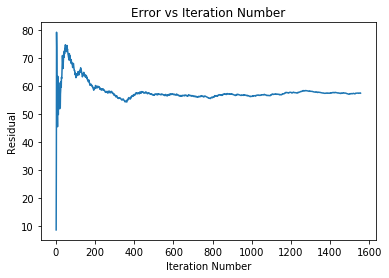

In [18]:
#x_train = x_TRAIN 
#y_train = data_TRAIN
HKvars = [40e3,40e3,-50e3] #E1,N1
HKres = leastsq(get_H_K_model,HKvars,args=(x_train,y_train))
R_square,savedError = compute_error(HKres.x,y_train,x_train)
res = residual(HKres.x,y_train,x_train)
#print(res)
#print(R_square)
plt.plot(range(len(y_train)),savedError) #R squared
#plt.plot(range(len(y_train)),res) #Residual
plt.xlabel("Iteration Number")
plt.ylabel("Residual") 
plt.title("Error vs Iteration Number")

# K-Fold Cross Validation Method

Although the train-test-split method works. It is possible to overfit the model. Here this concept is explained well: https://medium.com/towards-data-science/train-test-split-and-cross-validation-in-python-80b61beca4b6 . Futhermore,this video explains cross validation very well along with a clear explanation as to why the K-fold method is better to avoid over/under-fitting a model: https://www.youtube.com/watch?v=6dbrR-WymjI

How it K-Fold Cross Validation works:

1. Split the dataset into K equal parts ("folds")
2. Use the first fold as the testing set and all the other folds as the training set.
3. Calculate the testing accuracy
4. Repeat step 2 and 3 K times, using a different fold as the testing set each time.
5. Use the average testing accuracy as the estimate of the out-of-sample accuracy.

<img src="files/5fold.png">

In [19]:
def kfoldfunc():
    n=10
    kf = KFold(n_folds=n)
    sum = 0
    for train, test in kf.split(data):
        train_data = np.array(data)[train]
        test_data = np.array(data)[test]
        gmodel = Model(get_MAXWELLmodel)
        gmodel.fit(y, x=x, E1=40e3, N1=-50e3, N2 = 0)
        #sum += errors 
    average = sum/n
    return